In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from itertools import combinations_with_replacement
from functools import reduce
from operator import mul
from math import factorial
import einops
from koopman.simulation.simulator import simulate, simulate_batch
from koopman.simulation.systems import DynamicalSystem, NonlinearAttractor2D
from koopman.edmd.edmd import eDMD
from sklearn.preprocessing import PolynomialFeatures
from spatialmath.base import angle_wrap
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import PolynomialFeatures

def get_random_visible_color():
    # Sample hue randomly, fix saturation and value for vibrancy
    h = np.random.rand()           # Hue ∈ [0, 1]
    s = np.random.uniform(0.6, 1)  # Saturation: avoid pale colors
    v = np.random.uniform(0.7, 1)  # Value (brightness): avoid dark
    return mcolors.hsv_to_rgb((h, s, v))

In [12]:
# Run a simulation with a pendulum
attractor = NonlinearAttractor2D(NonlinearAttractor2D.Params(mu=2.0, lam=0.5))

N = 1000
x0 = np.random.uniform(-10, 10, (N, 2))
tf = 5.0
dt = 0.05
controls = np.random.randn(N, int(tf/dt), 1) * 5.0

ts, xhist, uhist = simulate_batch(
    sys=attractor,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

print("ts:", ts.shape)
print("xhist:", xhist.shape)
print("uhist:", uhist.shape)

Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 13697.03it/s]

ts: (101,)
xhist: (1000, 101, 2)
uhist: (1000, 100, 1)


In [32]:
def koopman_observables(xhist: np.ndarray) -> np.ndarray:
    is_batched = xhist.ndim == 2
    if not is_batched:
        xhist = np.expand_dims(xhist, axis=0)
    
    x1, x2 = xhist[:, 0], xhist[:, 1]
    
    Y = np.column_stack([
        x1 ** 2,
    ])
    
    out = np.concatenate([xhist, Y], axis=-1)
    
    if not is_batched:
        return np.squeeze(out, axis=0)
    else:
        return out

# Fit the eDMD model to pendulum data using degree 4 polynomial observables of sin/cos/omega
edmd = eDMD()
zhist = edmd.apply_observable_to_history(xhist, koopman_observables)

print(np.max(zhist))
print(np.min(zhist))
print(np.isnan(zhist).any())
print(np.isinf(zhist).any())

assert np.allclose(zhist[:, 0, :NonlinearAttractor2D.nx], xhist[:, 0, :])

_ = edmd.fit(zhist , uhist)

99.96614466611472
-9.998307090008524
False
False
zhist shape: (1000, 101, 3)
uhist shape: (1000, 100, 1)
Number of samples: 1000
Number of time steps: 101
Number of states: 3
Number of controls: 1
kpA shape: (3, 3)
kpB shape: (3, 1)
Condition number of kpA: 1.1933588913220068
Condition number of kpB: 1.0


Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 39158.85it/s]


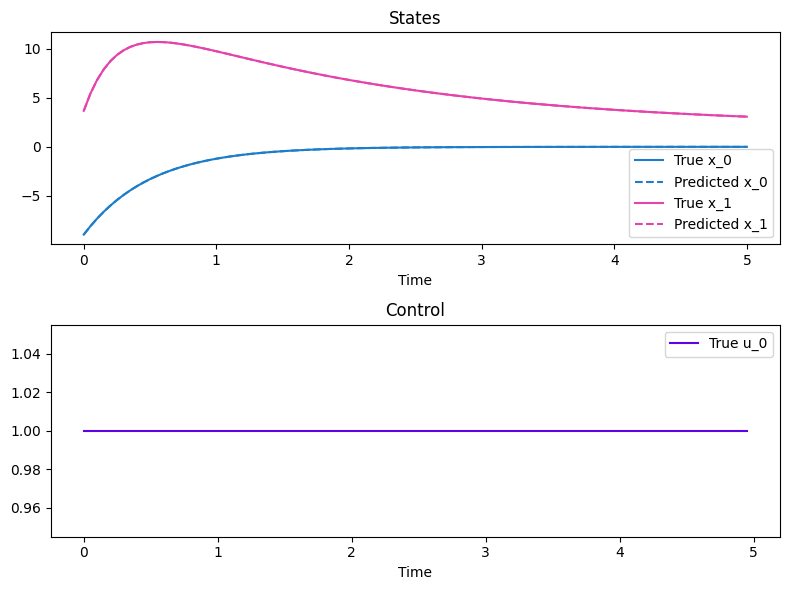

In [30]:
# Evaluate the model on some new data
x0 = np.random.uniform(-10, 10, 2) #np.array([5.0, -5.0]) #np.concatenate((theta0, omega0))
controls = np.ones((int(tf/dt), NonlinearAttractor2D.nu)) #np.squeeze(generate_random_smooth_controls(1, int(tf/dt)), axis=0)

eval_ts, eval_xhist, eval_uhist = simulate(
    sys=attractor,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

zjm1 = koopman_observables(x0)

eval_xhist_pred = np.empty_like(eval_xhist)
eval_xhist_pred[0] = edmd.project_to_x(zjm1, NonlinearAttractor2D.nx)

for i, t in enumerate(eval_ts[:-1]):
    zj = edmd.predict_z_next(zjm1, controls[i])
    eval_xhist_pred[i + 1] = edmd.project_to_x(zj, NonlinearAttractor2D.nx)
    
    zjm1 = zj

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
for i in range(NonlinearAttractor2D.nx):
    color = get_random_visible_color()
    ax[0].plot(eval_ts, eval_xhist[:, i], color=color, label=f"True x_{i}")
    ax[0].plot(eval_ts, eval_xhist_pred[:, i], color=color, linestyle='--', label=f"Predicted x_{i}")
    
ax[0].set_title("States")
ax[0].set_xlabel("Time")
ax[0].legend()

for i in range(NonlinearAttractor2D.nu):
    color = get_random_visible_color()
    ax[1].plot(eval_ts[:-1], eval_uhist[:, i], color=color, label=f"True u_{i}")

ax[1].set_title("Control")
ax[1].set_xlabel("Time")
ax[1].legend()

plt.tight_layout()
plt.show()